Single track sideband added

In [1]:
card_name = 'v6'

In [2]:
fit_real_data = False
category = 'low'
SM_RDst = 0.26

# Import

In [3]:
import sys, os, pickle
from glob import glob
sys.path.append('../lib')
sys.path.append('../analysis')
from categoriesDef import categories
import itertools
import json, yaml
from IPython.display import IFrame, Image, display

In [4]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from array import array

import uproot as ur
import ROOT as rt
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)
import root_numpy as rtnp

from analysis_utilities import drawOnCMSCanvas, getEff, DSetLoader
from pT_calibration_reader import pTCalReader
from histo_utilities import create_TH1D, create_TH2D, std_color_list
from gridVarQ2Plot import plot_gridVarQ2, plot_SingleAddTkMassHad
from progressBar import ProgressBar
from lumi_utilities import getLumiByTrigger

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1

if fit_real_data:
    CMS_lumi.extraText = "     Preliminary"
else:
    CMS_lumi.extraText = "     Simulation Preliminary"

donotdelete = []

Welcome to JupyROOT 6.12/07


In [5]:
cat = categories[category]

# Define binning

In [6]:
binning = {
    'M2_miss' : [
        array('d', [-2.5] + list(np.arange(-1.8, 0.8, 0.4)) + [8] ),
        array('d', [-2.5] + list(np.arange(-1.8, 3.0, 0.4)) + [8] ),
        array('d', [-2.5] + list(np.arange(-1.8, 5.2, 0.4)) + [8] ),
        array('d', [-2.5] + list(np.arange(-1.8, 7.6, 0.4)) + [8] ),
    ],
    'Est_mu'  : [
        array('d', [0.3] + list(np.arange(0.8, 2.3, 0.1)) + [2.5] ),
        array('d', [0.3] + list(np.arange(0.8, 2.5, 0.1)) + [2.5] ),
        [20, 0.3, 2.500],
        [20, 0.3, 2.500],
    ],
    'tkMassHad_0' : [40, 2.13, 2.73]
}
if fit_real_data:
    binning['q2'] = array('d', [-2, 1.5, 4, 6])
else:
    binning['q2'] = array('d', [-2, 2.5, 6, 9.4, 12])

# Load the datasets

In [7]:
MCsample = {
'mu' : DSetLoader('B0_MuNuDmst_PU20'),
'tau' : DSetLoader('B0_TauNuDmst_PU20'),
'Hc' : DSetLoader('B0_DmstHc_PU20'),
'Dstst' : DSetLoader('Bp_MuNuDstst_PU20')
}
dSet = {}
dSetTkSide = {}
for n, s in MCsample.iteritems():
    dSet[n] = rtnp.root2array(s.skimmed_dir + '/{}_corr.root'.format(cat.name))
    dSetTkSide[n] = rtnp.root2array(s.skimmed_dir + '/{}_skip17_corr.root'.format(cat.name))    

In [8]:
if fit_real_data:
    creation_date = '200410'
    locRD = '../data/cmsRD/skimmed/B2DstMu_{}_{}'.format(creation_date, cat.name)
    dSet['data'] = rtnp.root2array(locRD + '_corr.root')
    dSetTkSide['data'] = rtnp.root2array(locRD + '_skip17_corr.root')
    dataDir = '../data/cmsRD'
    datasets_loc = glob(dataDir + '/ParkingBPH*/*RDntuplizer_B2DstMu_{}_CAND.root'.format(creation_date))
    lumi_tot = getLumiByTrigger(datasets_loc, cat.trg, verbose=True)
    CMS_lumi.integrated_lumi = lumi_tot
else:
    expectedLumi = {'low':6., 'mid':20., 'high':26.} #fb^-1
    lumi_tot = expectedLumi[category]

# Load all the calibrations

In [9]:
r = np.zeros((3,2))
for i, fn in enumerate(glob('../data/calibration/totalRate/ratioB02JPsiKst_*.txt')):
    with open(fn, 'r') as faux:
        aux = faux.readlines()[0][:-1].split(' ')
        r[i] = [float(aux[0]), float(aux[1])]
s2 = np.square(r[:,1])
num = np.sum(r[:,0]/s2)
den = np.sum(1./s2)
RDoMC_normRatio = [num/den, np.sqrt(1/den)]
print 'Expected ratio between RD and MC norm: {:.3f} +/- {:.3f}'.format(RDoMC_normRatio[0], RDoMC_normRatio[1])

Expected ratio between RD and MC norm: 2.632 +/- 0.063


In [10]:
decayBR = pickle.load(open('../data/forcedDecayChannelsFactors.pickle', 'rb'))

In [11]:
loc = '../data/calibration/triggerScaleFactors/'
fTriggerSF = rt.TFile.Open(loc + 'HLT_' + cat.trg + '_SF.root', 'READ')
hTriggerSF = fTriggerSF.Get('hSF_HLT_' + cat.trg)

In [12]:
def computeTrgSF(ds, selection=None):
    trgSF = np.ones_like(ds['q2'])
    trgSFUnc = np.ones_like(ds['q2'])
    ptmax = hTriggerSF.GetXaxis().GetXmax() - 0.01
    ipmax = hTriggerSF.GetYaxis().GetXmax() - 0.01
    etamax = hTriggerSF.GetZaxis().GetXmax() - 0.01
    x = np.column_stack((ds['mu_pt'], ds['mu_eta'], ds['mu_sigdxy']))
    if not selection is None:
        x = x[sel]
    for i, (pt, eta, ip) in enumerate(x):
        ix = hTriggerSF.GetXaxis().FindBin(min(ptmax, pt))
        iy = hTriggerSF.GetYaxis().FindBin(min(ipmax, ip))
        iz = hTriggerSF.GetZaxis().FindBin(min(etamax, np.abs(eta)))
        trgSF[i] = hTriggerSF.GetBinContent(ix, iy, iz)
        ib = hTriggerSF.GetBin(ix, iy, iz)
        trgSFUnc[i] = hTriggerSF.GetBinError(ib)
        if trgSF[i] == 0:
            print pt, ip, np.abs(eta)
            raise
    # Divide them for the weight so later you can simply multiply back to get the value
    up = 1 + trgSFUnc/trgSF
    down = 1 - trgSFUnc/trgSF
    return trgSF, up, down

In [13]:
fMuonIDSF = rt.TFile.Open('../data/calibration/muonIDscaleFactors/Run2018ABCD_SF_MuonID_Jpsi.root', 'READ')
hMuonIDSF = fMuonIDSF.Get('NUM_SoftID_DEN_genTracks_pt_abseta')

In [14]:
def computeMuonIDSF(ds):
    muonSF = np.ones_like(ds['q2'])
    muonSFUnc = np.ones_like(ds['q2'])
    ptmax = hMuonIDSF.GetXaxis().GetXmax() - 0.01
    etamax = hMuonIDSF.GetYaxis().GetXmax() - 0.01
    x = np.column_stack((ds['MC_mu_pt'], ds['MC_mu_eta']))
    for i, (pt, eta) in enumerate(x):
        ix = hMuonIDSF.GetXaxis().FindBin(min(pt, ptmax))
        if ix == 0: ix = 1 #Remove underflows (Meaning that the MC matching failed)
        iy = hMuonIDSF.GetYaxis().FindBin(min(np.abs(eta), etamax))
        muonSF[i] = hMuonIDSF.GetBinContent(ix, iy)
        muonSFUnc[i] = hMuonIDSF.GetBinError(hMuonIDSF.GetBin(ix, iy))
        if muonSF[i] == 0:
            print pt, eta
            print ix, iy
            raise
    up = 1 + muonSFUnc/muonSF
    down = 1 - muonSFUnc/muonSF
    return muonSF, up, down

In [15]:
cal_pT = pTCalReader(calibration_file='../data/calibration/B0pTspectrum/pwWeights_{}.txt'.format(cat.name))

In [16]:
def computeB0pTweights(ds):
    # The denominator (sum of weights) for this weights is not known but it cancel out in the ratio
    w = cal_pT.f['C'](ds['MC_B_pt'])
    if np.sum(w==0):
        print np.sum(w==0)
        raise
    up = cal_pT.f['Up'](ds['MC_B_pt'])/w
    down = cal_pT.f['Down'](ds['MC_B_pt'])/w
    return w, up, down

# Create MC histograms

In [17]:
histo = {}

### Signal region

In [18]:
for n, ds in dSet.iteritems():
    if n == 'data': continue
    print '\n----------->', n, '<-------------'
    sMC = MCsample[n]
    
    nTotSelected = ds['q2'].shape[0]
    print 'N tot selected: {:.1f}k'.format(1e-3*nTotSelected)
    nGenExp = sMC.effMCgen['xsec'][0] * lumi_tot * RDoMC_normRatio[0]
    eff = [1, 0]
    for f, df in [sMC.effMCgen['effGEN'], decayBR[n], sMC.effCand['effCAND'], sMC.getSkimEff(cat.name+'_corr')]:
        eff[0] *= f
        eff[1] += np.square(df/f)
    eff[1] = eff[0] * np.sqrt(eff[1])
    sMC.effTotRelUncert = eff[1]/eff[0]
    nTotExp = nGenExp*eff[0]
    print 'N tot expected (before weights): {:.1f}k'.format(1e-3*nTotExp)
    
    wVar = {}
    weights = {}
    
    print 'Including trigger corrections'
    weights['trgSF'], wVar['trgSFUp'], wVar['trgSFDown'] = computeTrgSF(ds)
    print 'Including muon ID corrections'
    weights['muonIdSF'], wVar['muonIdSFUp'], wVar['muonIdSFDown'] = computeMuonIDSF(ds)
    if n in ['mu', 'tau', 'Hc']: #B0 dominated final states (probably we should do something about B+ too)
        print 'Including B0 pT corrections'
        weights['B0pT'], wVar['B0pTUp'], wVar['B0pTDown'] = computeB0pTweights(ds)
        print 'Average weight: {:.3f}'.format(np.average(weights['B0pT']))
    
    # Hammer corrections to the FF
    if n in ['mu', 'tau']:
        print 'Including FF corrections (Hammer)'
        weights['B2DstCLN'] = ds['wh_CLNCentral']*sMC.effCand['rate_den']/sMC.effCand['rate_Central']
        for nPar in ['R0', 'R1', 'R2', 'RhoSq']:
            for var in ['Up', 'Down']:
                tag = 'CLN' + nPar + var
                wVar['B2Dst'+tag] = ds['wh_'+tag]/sMC.effCand['rate_' + nPar + var]
                wVar['B2Dst'+tag] *= sMC.effCand['rate_Central']/ds['wh_CLNCentral']
    
    print 'Computing total weights'
    weightsCentral = np.ones_like(ds['q2'])
    for w in weights.values(): weightsCentral *= w
    print 'N tot expected (after weights): {:.1f}k'.format(1e-3*nTotExp*np.sum(weightsCentral)/nTotSelected)
    wVar[''] = np.ones_like(weightsCentral)
    
    for i_q2 in range(len(binning['q2'])-1):
        q2_l = binning['q2'][i_q2]
        q2_h = binning['q2'][i_q2 + 1]
        sel_q2 = np.logical_and(ds['q2'] > q2_l, ds['q2'] < q2_h)
        for var in ['M2_miss', 'Est_mu']:
            cat_name = var+'_q2bin'+str(i_q2)
            
            if not cat_name in histo.keys():
                histo[cat_name] = {}
            
            for name_wVar, v_wVar in wVar.iteritems():
                h_name = n
                if not name_wVar == '':
                    h_name += '__' + name_wVar
                w = weightsCentral*v_wVar
                scale = nTotExp/nTotSelected
                histo[cat_name][h_name] = create_TH1D(
                                                      ds[var][sel_q2], 
                                                      name=h_name, title=h_name, 
                                                      binning=binning[var][i_q2], 
                                                      opt='underflow,overflow',
                                                      weights=w[sel_q2], scale_histo=scale,
                                                      )


-----------> mu <-------------
N tot selected: 346.5k
N tot expected (before weights): 118.4k
Including trigger corrections
Including muon ID corrections
Including B0 pT corrections
Average weight: 0.999
Including FF corrections (Hammer)
Computing total weights
N tot expected (after weights): 109.0k

-----------> tau <-------------
N tot selected: 47.0k
N tot expected (before weights): 6.0k
Including trigger corrections
Including muon ID corrections
Including B0 pT corrections
Average weight: 1.057
Including FF corrections (Hammer)
Computing total weights
N tot expected (after weights): 5.9k

-----------> Hc <-------------
N tot selected: 14.8k
N tot expected (before weights): 1.0k
Including trigger corrections
Including muon ID corrections
Including B0 pT corrections
Average weight: 1.068
Computing total weights
N tot expected (after weights): 1.0k

-----------> Dstst <-------------
N tot selected: 18.2k
N tot expected (before weights): 4.3k
Including trigger corrections
Including mu

### Single track side

In [19]:
histo['SingleAddTkMassHad'] = {}
for n, ds in dSetTkSide.iteritems():
    if n == 'data': continue
    print '\n----------->', n, '<-------------'
    sMC = MCsample[n]
    
    sel = ds['N_goodAddTks'] == 1
    sel = np.logical_and(sel, np.abs(ds['tkMassHad_0'] - 2.43) < 0.3)
    nTotSelected = np.sum(sel)
    print 'N tot selected: {:.0f}'.format(nTotSelected)
    nGenExp = sMC.effMCgen['xsec'][0] * lumi_tot * RDoMC_normRatio[0]
    eff = [1, 0]
    for f, df in [sMC.effMCgen['effGEN'], 
                  decayBR[n], 
                  sMC.effCand['effCAND'], 
                  sMC.getSkimEff(cat.name+'_skip17_corr'),
                  getEff(nTotSelected, sel.shape[0])
                 ]:
        eff[0] *= f
        eff[1] += np.square(df/f)
    eff[1] = eff[0] * np.sqrt(eff[1])
    sMC.effTotRelUncert = eff[1]/eff[0]
    nTotExp = nGenExp*eff[0]
    print 'N tot expected (before weights): {:.0f}'.format(nTotExp)
    
    wVar = {}
    weights = {}
    
    print 'Including trigger corrections'
    weights['trgSF'], wVar['trgSFUp'], wVar['trgSFDown'] = computeTrgSF(ds)
    print 'Including muon ID corrections'
    weights['muonIdSF'], wVar['muonIdSFUp'], wVar['muonIdSFDown'] = computeMuonIDSF(ds)
    if n in ['mu', 'tau', 'Hc']: #B0 dominated final states (probably we should do something about B+ too)
        print 'Including B0 pT corrections'
        weights['B0pT'], wVar['B0pTUp'], wVar['B0pTDown'] = computeB0pTweights(ds)
        print 'Average weight: {:.3f}'.format(np.average(weights['B0pT']))
    
    # Hammer corrections to the FF
    if n in ['mu', 'tau']:
        print 'Including FF corrections (Hammer)'
        weights['B2DstCLN'] = ds['wh_CLNCentral']*sMC.effCand['rate_den']/sMC.effCand['rate_Central']
        for nPar in ['R0', 'R1', 'R2', 'RhoSq']:
            for var in ['Up', 'Down']:
                tag = 'CLN' + nPar + var
                wVar['B2Dst'+tag] = ds['wh_'+tag]/sMC.effCand['rate_' + nPar + var]
                wVar['B2Dst'+tag] *= sMC.effCand['rate_Central']/ds['wh_CLNCentral']
    
    print 'Computing total weights'
    weightsCentral = np.ones_like(ds['q2'])
    for w in weights.values(): weightsCentral *= w
    print 'N tot expected (after weights): {:.0f}'.format(nTotExp*np.sum(weightsCentral[sel])/nTotSelected)
    wVar[''] = np.ones_like(weightsCentral)
            
    for name_wVar, v_wVar in wVar.iteritems():
        h_name = n
        if not name_wVar == '':
            h_name += '__' + name_wVar
        w = weightsCentral*v_wVar
        scale = nTotExp/nTotSelected
        histo['SingleAddTkMassHad'][h_name] = create_TH1D(
                                              ds['tkMassHad_0'][sel], 
                                              name=h_name, title=h_name, 
                                              binning=binning['tkMassHad_0'], 
                                              opt='underflow,overflow',
                                              weights=w[sel], scale_histo=scale,
                                              )


-----------> mu <-------------
N tot selected: 28711
N tot expected (before weights): 9814
Including trigger corrections
Including muon ID corrections
Including B0 pT corrections
Average weight: 0.998
Including FF corrections (Hammer)
Computing total weights
N tot expected (after weights): 9090

-----------> tau <-------------
N tot selected: 2966
N tot expected (before weights): 375
Including trigger corrections
Including muon ID corrections
Including B0 pT corrections
Average weight: 1.056
Including FF corrections (Hammer)
Computing total weights
N tot expected (after weights): 373

-----------> Hc <-------------
N tot selected: 3902
N tot expected (before weights): 274
Including trigger corrections
Including muon ID corrections
Including B0 pT corrections
Average weight: 1.082
Computing total weights
N tot expected (after weights): 284

-----------> Dstst <-------------
N tot selected: 30958
N tot expected (before weights): 7370
Including trigger corrections
Including muon ID corre

# Create (pseudo-)data histogram

In [20]:
if fit_real_data:
    ds = dSet['data']
    print 'N observed data: {:.1f}k'.format(1e-3*ds['q2'].shape[0])
    for i_q2 in range(len(binning['q2'])-1):
        q2_l = binning['q2'][i_q2]
        q2_h = binning['q2'][i_q2 + 1]
        sel_q2 = np.logical_and(ds['q2'] > q2_l, ds['q2'] < q2_h)
        for var in ['M2_miss', 'Est_mu']:
            cat_name = var+'_q2bin'+str(i_q2)     
            histo[cat_name]['data'] = create_TH1D(
                                                  ds[var][sel_q2], 
                                                  name='data_obs', title='Data Obs',
                                                  binning=binning[var][i_q2],
                                                  opt='underflow,overflow'
                                                 )
    ds = dSetTkSide['data']
    sel = ds['N_goodAddTks'] == 1
    sel = np.logical_and(sel, np.abs(ds['tkMassHad_0'] - 2.43) < 0.3)
    histo['SingleAddTkMassHad']['data'] = create_TH1D(
                                          ds['tkMassHad_0'][sel], 
                                          name='data_obs', title='Data Obs',
                                          binning=binning['tkMassHad_0'], 
                                          opt='underflow,overflow'
                                          )
else:
    for i_q2 in range(len(binning['q2'])-1):
        for var in ['M2_miss', 'Est_mu']:
            cat_name = var+'_q2bin'+str(i_q2)
            
            h = create_TH1D(np.array([0, 0]), name='data_obs', title='Data Obs', binning=binning[var][i_q2])
            h.Reset()
            for n, hMC in histo[cat_name].iteritems():
                if not '__' in n and not n == 'data':
                    scale = SM_RDst if 'tau' in n else 1.
                    h.Add(hMC, scale)
            h.Sumw2(0)
            for i in range(1, h.GetNbinsX()+1):
                h.SetBinContent(i, np.around(h.GetBinContent(i)))
            h.Sumw2()
            histo[cat_name]['data'] = h
    h = create_TH1D(np.array([0, 0]), name='data_obs', title='Data Obs', binning=binning['tkMassHad_0'])
    h.Reset()
    for n, hMC in histo['SingleAddTkMassHad'].iteritems():
        if not '__' in n and not n == 'data':
            scale = SM_RDst if 'tau' in n else 1.
            h.Add(hMC, scale)
    h.Sumw2(0)
    for i in range(1, h.GetNbinsX()+1):
        h.SetBinContent(i, np.around(h.GetBinContent(i)))
    h.Sumw2()
    histo['SingleAddTkMassHad']['data'] = h

In [21]:
histo_file_dir = '../data/_root/histos4combine/'
if not os.path.isdir(histo_file_dir):
    os.makedirs(histo_file_dir)
histo_file_loc = {}
for cat_name, h_dic in histo.iteritems():
    histo_file_loc[cat_name] = histo_file_dir+'{}_{}.root'.format(card_name, cat_name)
    tf = rt.TFile(histo_file_loc[cat_name], 'recreate')
    for v in h_dic.values():
        v.Write()
    tf.Close()

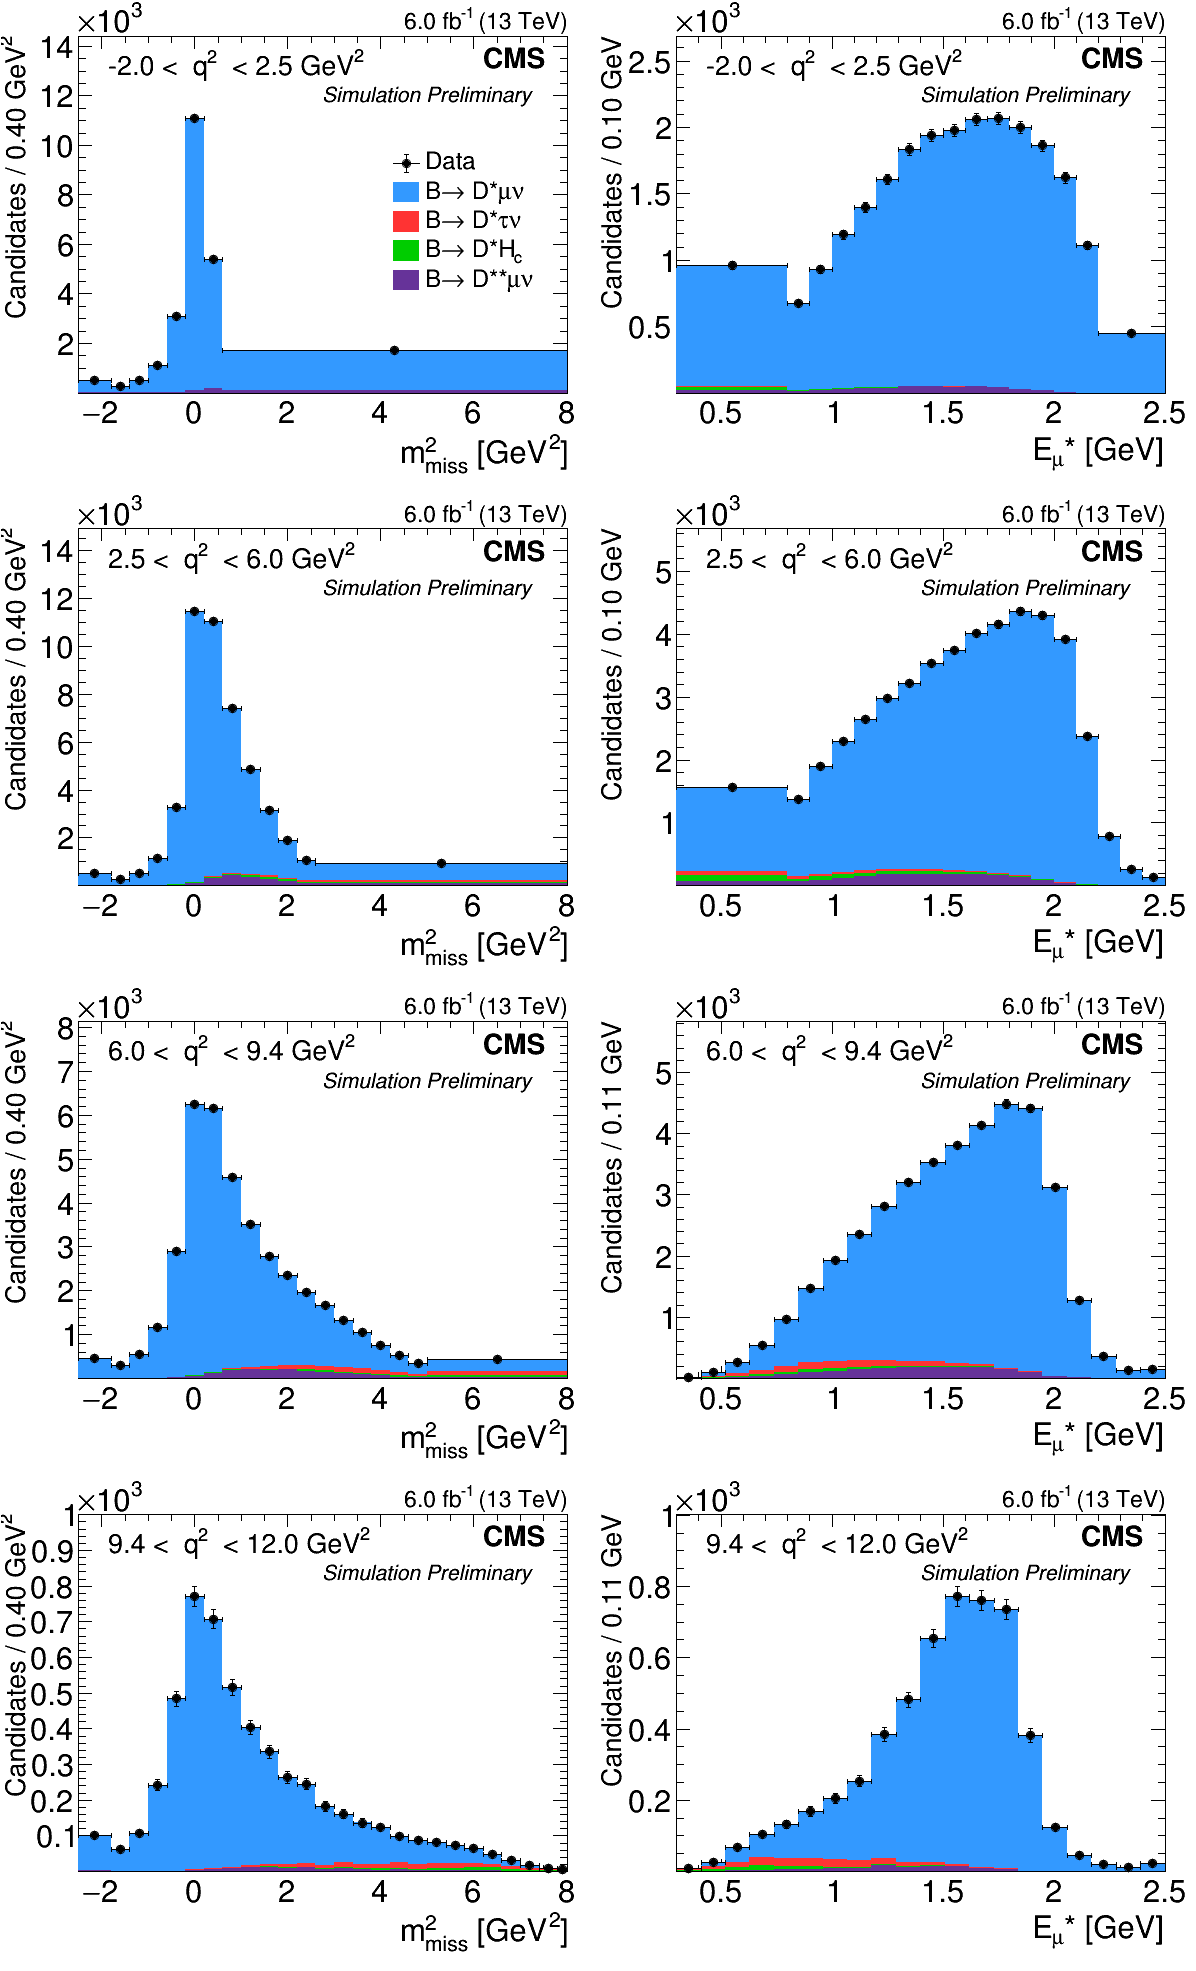

In [22]:
CMS_lumi.integrated_lumi = lumi_tot
scale_dic = {'tau': SM_RDst
            }

c = plot_gridVarQ2(CMS_lumi, binning, histo, scale_dic=scale_dic, min_y=1, logy=False)

# CMS_lumi.integrated_lumi = ''
# histNorm = {}
# for k, hdic in histo.iteritems():
#     if not k in histNorm.keys():
#         histNorm[k] = {}
#     for kk, h in hdic.iteritems():
#         hAux = h.Clone()
#         hAux.Scale(1./float(N_data))
#         histNorm[k][kk] = hAux

# c = plot_gridVarQ2s(CMS_lumi, binning, histNorm, scale_dic, min_y=1, logy=False, iPad_legend=7)

In [ ]:
c = plot_SingleAddTkMassHad(CMS_lumi, histo, scale_dic=scale_dic, min_y=1, logy=False)

# Write the card

In [ ]:
sig_processes = ['tau', 'mu']
bkg_processes = ['Hc', 'Dstst']
processes = sig_processes + bkg_processes
nProc = len(processes)
categories = np.sort([k for k in histo.keys() if not '__' in k])
nCat = len(categories)

In [ ]:
card_location = 'cards/{}.txt'.format(card_name)
fc = open(card_location, 'w')

In [ ]:
# number of different categories
card = 'imax *\n'
# number of processes minus one
card += 'jmax {}\n'.format(len(processes)-1)
# number of nuissance parameters
card += 'kmax *\n'
card += '--------------------------------------------------------------\n'

# shape file location
for k in categories:
    card += 'shapes * {} {} $PROCESS $PROCESS__$SYSTEMATIC\n'.format(k, histo_file_loc[k])
card += '--------------------------------------------------------------\n'

# number of events observed
card += 'bin ' + ' '.join(categories) + '\n'
obs = map(lambda k: '{:.0f}'.format(histo[k]['data'].Integral()), categories)
obs = ' '.join(obs)
card += 'observation ' + obs + '\n'
card += '--------------------------------------------------------------\n'


# MC expected events
aux_bin = ''
aux_proc_name = ''
aux_proc_id = ''
aux_proc_rate = ''
for c, p in itertools.product(categories, processes):
    aux_bin += ' '+c
    aux_proc_name += ' '+p
    aux_proc_id += ' '+str(np.argmax(np.array(processes) == p))
    aux_proc_rate += ' {:.4f}'.format(histo[c][p].Integral())
    
card += 'bin' + aux_bin + '\n'
card += 'process' + aux_proc_name + '\n'
# Zero or negative for sig and positive for bkg
card += 'process' + aux_proc_id + '\n'
# Expected rate
card += 'rate' + aux_proc_rate + '\n'
card += '--------------------------------------------------------------\n'

### Systematic uncertainties

Scale systematics

In [ ]:
#pp -> bb cros-section * luminosity
card += 'xsecpp2bbXlumi lnN' + ' 1.9'*nProc*nCat + '\n'

In [ ]:
#Hadronization fraction of B0
aux = ''
for n in processes:
    if n in ['tau', 'mu', 'Hc']: aux += ' 2'
    else: aux += ' -'
card += 'b2B0Had lnN' + aux*nCat + '\n'

In [ ]:
#Hadronization fraction of B+
# aux = ''
# for n in processes:
#     if n in ['Dstst']: aux += ' 3'
#     else: aux += ' -'
# card += 'b2BpHad lnN' + aux*nCat + '\n'

In [ ]:
# Selection efficiencies
for n in processes:
    if n == 'tau': continue
    val = ' {:.3f}'.format(1+MCsample[n].effTotRelUncert)
    if n == 'Dstst':
        val = ' 3.'
    aux = ''
    for nn in processes:
        if nn == n: aux += val
        else: aux += ' -'
    card += n + 'Eff lnN' + aux*nCat + '\n'

In [ ]:
card += '--------------------------------------------------------------\n'

Shape Systematics

In [ ]:
card += 'trgSF shape' + ' 1.'*nProc*nCat + '\n'

In [ ]:
card += 'muonIdSF shape' + ' 1.'*nProc*nCat + '\n'

In [ ]:
# B0 pT spectrum
aux = ''
for p in processes:
    if p in ['tau', 'mu', 'Hc']:
        aux += ' 1.'
    else:
        aux += ' -'
card += 'B0pT shape' + aux*nCat + '\n'

In [ ]:
# Form Factors from Hammer
for n_pFF in ['R0', 'R1', 'R2', 'RhoSq']:
    aux = ''
    for p in processes:
        if p in ['tau', 'mu']:
            aux += ' 1.'
        else:
            aux += ' -'
    card += 'B2DstCLN{} shape'.format(n_pFF) + aux*nCat + '\n'

MC statistic systematics

In [ ]:
card += '* autoMCStats 0 1 1\n'
card += '--------------------------------------------------------------\n'

Defining groups of systematics

In [ ]:
# autoMCStats group = defined by default when using autoMCStats
aux_FF = ' '.join(['B2DstCLN'+n for n in ['R0', 'R1', 'R2', 'RhoSq']])
card += 'B2DstFF group = ' + aux_FF + '\n'

# card += 'normMC group = xsecpp2bbXlumi b2B0Had b2BpHad\n'
card += 'normMC group = xsecpp2bbXlumi b2B0Had\n'

card += 'effMC group = ' + ' '.join([n+'Eff' for n in processes if not n == 'tau']) + '\n'

card += 'allShape group = trgSF muonIdSF B0pT ' + aux_FF + '\n'

In [ ]:
print card

In [ ]:
fc.write(card)
fc.close()

### Create output directory

In [ ]:
outdir = 'results/' + card_name

if os.path.isdir(outdir):
    os.system('rm -rf ' + outdir)
os.system('mkdir ' + outdir);

# Run Combine

## Create the workspace

In [ ]:
cmd = 'text2workspace.py ' + card_location 
cmd += ' -o ' + card_location.replace('.txt', '.root')
cmd += ' --no-b-only'
cmd += ' --verbose 1'
# cmd += ' --no-wrappers'
os.system(cmd)

### Run the Maximum Likelyhood fit

In [ ]:
1 if fit_real_data else 2

In [ ]:
cmd = 'combine -M FitDiagnostics'
cmd += ' --robustFit 1 --cminDefaultMinimizerStrategy {} --X-rtd MINIMIZER_analytic'.format(1 if fit_real_data else 2)
cmd += ' --skipBOnlyFit'
cmd += ' -d ' + card_location.replace('.txt', '.root')
cmd += ' -D ' + histo[histo.keys()[0]]['data'].GetName()
cmd += ' --setParameters r={:.2f}'.format(SM_RDst)
cmd += ' --setParameterRanges r=0.001,1'
cmd += ' -n {}'.format(card_name)
cmd += ' --out ' + outdir
cmd += ' --saveShapes --saveWithUncertainties --saveNormalizations'
cmd += ' --plots'
cmd += ' --verbose 1'

print cmd
os.system(cmd)
os.system('mv combine_logger.out ' + outdir + '/')
os.system('mv ./*.root ' + outdir + '/')

In [ ]:
cmd = 'python diffNuisances.py '.format(os.environ['CMSSW_BASE'])
cmd += glob(outdir + '/fitDiagnostics{}.root'.format(card_name))[0]
cmd += ' --skipFitB'
cmd += ' -g {}/nuisance_pull.root'.format(outdir)
print cmd
os.system(cmd)

In [ ]:
f = ur.open(glob(outdir + '/higgsCombine{}.FitDiagnostics.mH120.root'.format(card_name))[0])
c, d, u, _ = f['limit']['limit'].array()
print 'R(D*) = {:.3f} +{:.3f}/-{:.3f} [{:.1f} %]'.format(c, u-c, c-d, 100*(u-d)*0.5/c)


In [ ]:
# Get post-fit shapes
f = rt.TFile.Open(glob(outdir + '/fitDiagnostics{}.root'.format(card_name))[0], 'READ')
fd = f.shapes_fit_s

histo_postfit = {}
for cat, h_dic in histo.iteritems():
    histo_postfit[cat] = {}
    for n, h in h_dic.iteritems():
        if '__' in n:
            continue
        h_post = h.Clone(h.GetName() + '_postfit')
        if 'data' in n:
            h_fit = fd.Get(cat+'/total')
            h_data = h.Clone(h.GetName() + '_data')
            for i in range(1, h_post.GetNbinsX()+1):
                h_post.SetBinContent(i, h_fit.GetBinContent(i))
                h_post.SetBinError(i, h_fit.GetBinError(i))     
            
            histo_postfit[cat]['total'] = h_post
            histo_postfit[cat][n] = h_data
        else:
            h_fit = fd.Get(cat+'/'+n)
            for i in range(1, h_post.GetNbinsX()+1):
                h_post.SetBinContent(i, h_fit.GetBinContent(i))
                h_post.SetBinError(i, h_fit.GetBinError(i)) 

            histo_postfit[cat][n] = h_post

In [ ]:
c_out = plot_gridVarQ2(CMS_lumi, binning, histo_postfit, scale_dic={}, draw_pulls=True, pulls_ylim=[0.9, 1.1])
c_out.SaveAs('gridPlot_test.png')

In [ ]:
CC = plot_SingleAddTkMassHad(CMS_lumi, histo_postfit, scale_dic={}, draw_pulls=True, pulls_ylim=[0.8, 1.2])

In [ ]:
h2 = f.Get('covariance_fit_s')
rt.gStyle.SetPaintTextFormat('.1f')

N = h2.GetNbinsX()
n=15

h2.GetXaxis().SetRange(1, n)
h2.GetYaxis().SetRangeUser(N-n, N)
h2.SetMarkerSize(1.3)
CC = drawOnCMSCanvas(CMS_lumi, [h2, h2], ['colz', 'text same'], tag='tl', mL=0.22, mR=0.15, mB=0.18)

### Run likelyhood scan

In [ ]:
def getUncertainty(name, verbose=True):
    f = ur.open(name)
    r_arr = f['limit']['r'].array()
    nll_arr = f['limit']['deltaNLL'].array()
    c = r_arr[0]
    r_u = r_arr[r_arr>r_arr[0]]
    nll_u = nll_arr[r_arr>r_arr[0]]
    f_u = interp1d(nll_u, r_u, 'quadratic')
    u = f_u(0.5)
    r_l = r_arr[r_arr<r_arr[0]]
    nll_l = nll_arr[r_arr<r_arr[0]]
    f_l = interp1d(nll_l, r_l, 'quadratic')
    l = f_l(0.5)
    if verbose:
        print '----------------------------------'
        print 'R(D*) = {:.3f} +{:.3f}/-{:.3f} [{:.1f} %]'.format(c, u-c, c-d, 100*(u-d)*0.5/c)
        print 'Sigma = {:.3f}'.format((u-l)*0.5)
        print '----------------------------------\n'
    return c, c-l, u-c, (u-l)*0.5

In [ ]:
cmd = 'combine'
cmd += ' -M MultiDimFit'
cmd += ' --algo grid --points=100'
cmd += ' --robustFit 1'
cmd += ' -d ' + card_location.replace('.txt', '.root')
cmd += ' -D ' + histo[histo.keys()[0]]['data'].GetName()
cmd += ' --X-rtd MINIMIZER_analytic'
cmd += ' --rMin={:.4f} --rMax={:.4f}'.format(c - 5*(c-d), c + 5*(u-c))
cmd += ' -n {}_nominal'.format(card_name)
cmd += ' --verbose -1'
print cmd
os.system(cmd)
cmd = 'plot1DScan.py higgsCombine{}_nominal.MultiDimFit.mH120.root'.format(card_name)
cmd += '; mv scan.png scan_nominal.png'
os.system(cmd)
res_nominal = getUncertainty('higgsCombine{}_nominal.MultiDimFit.mH120.root'.format(card_name))
display(Image(filename='scan_nominal.png'))

### Uncertainy breakdown by group

In [ ]:
cmd = 'combine -M MultiDimFit --algo none'
cmd += ' --cminDefaultMinimizerStrategy=2 --robustFit 1 --X-rtd MINIMIZER_analytic'
cmd += ' -d ' + card_location.replace('.txt', '.root')
cmd += ' -D ' + histo[histo.keys()[0]]['data'].GetName()
cmd += ' --setParameters r={:.2f}'.format(SM_RDst)
cmd += ' --setParameterRanges r=0.001,1'
cmd += ' -n {}_bestfit'.format(card_name)
cmd += ' --saveWorkspace --verbose -1'
print cmd
os.system(cmd);

In [ ]:
# Statistical uncertainty
cmd = 'combine -M MultiDimFit --algo grid --points=100'
cmd += ' --cminDefaultMinimizerStrategy=2 --robustFit 1 --X-rtd MINIMIZER_analytic'
cmd += ' -d higgsCombine{}_bestfit.MultiDimFit.mH120.root'.format(card_name)
cmd += ' -D ' + histo[histo.keys()[0]]['data'].GetName()
cmd += ' --rMin={:.4f} --rMax={:.4f}'.format(c - 5*(c-d), c + 5*(u-c))
cmd += ' -n {}_stat'.format(card_name)
cmd += ' --snapshotName MultiDimFit'
cmd += ' --freezeNuisanceGroups=autoMCStats,allShape'
cmd += ' --verbose -1'
print cmd
os.system(cmd);

In [ ]:
# MC Statistics
cmd = 'combine -M MultiDimFit --algo grid --points=100'
cmd += ' --cminDefaultMinimizerStrategy=2 --robustFit 1 --X-rtd MINIMIZER_analytic'
cmd += ' -d higgsCombine{}_bestfit.MultiDimFit.mH120.root'.format(card_name)
cmd += ' -D ' + histo[histo.keys()[0]]['data'].GetName()
cmd += ' --rMin={:.4f} --rMax={:.4f}'.format(c - 5*(c-d), c + 5*(u-c))
cmd += ' -n {}_MCstat'.format(card_name)
cmd += ' --snapshotName MultiDimFit'
cmd += ' --freezeNuisanceGroups=autoMCStats'
cmd += ' --verbose -1'
print cmd
os.system(cmd);

In [ ]:
cmd = 'plot1DScan.py higgsCombine{}_nominal.MultiDimFit.mH120.root'.format(card_name)
cmd += ' --others'
cmd += ' "higgsCombine{}_MCstat.MultiDimFit.mH120.root:Freeze MC stat:4"'.format(card_name)
cmd += ' "higgsCombine{}_stat.MultiDimFit.mH120.root:Freeze all:2"'.format(card_name)
cmd += ' --breakdown MCstat,syst,stat'
cmd += '; mv scan.png scan_MCstat.png'
print cmd
os.system(cmd)
display(Image(filename='scan_MCstat.png'))

In [ ]:
os.system('mv higgsCombine*.root ' + outdir + '/')
os.system('mv scan* ' + outdir + '/')
os.system('mv combine_logger.out ' + outdir + '/');

### Run the impact plots

Fit first the POI

In [ ]:
cmd = 'combineTool.py -M Impacts --doInitialFit -m 120'
cmd += ' --robustFit 1 --X-rtd MINIMIZER_analytic'
cmd += ' -d ' + card_location.replace('.txt', '.root')
cmd += ' -D ' + histo[histo.keys()[0]]['data'].GetName()
cmd += ' --setParameters r={:.2f}'.format(SM_RDst)
cmd += ' --setParameterRanges r=0.001,1'
cmd += ' -n {}'.format(card_name)
cmd += ' --out ' + outdir
cmd += ' --verbose -1'
os.system(cmd);

 Perform a similar scan for each nuisance parameter

In [ ]:
cmd = 'combineTool.py -M Impacts --doFits -m 120'
cmd += ' --robustFit 1 --X-rtd MINIMIZER_analytic'
cmd += ' --parallel 20'
cmd += ' -d ' + card_location.replace('.txt', '.root')
cmd += ' -D ' + histo[histo.keys()[0]]['data'].GetName()
cmd += ' -n {}'.format(card_name)
cmd += ' --verbose -1'
print cmd
os.system(cmd);

Collect the results

In [ ]:
cmd = 'combineTool.py -M Impacts -o impacts.json -m 120'
cmd += ' -d ' + card_location.replace('.txt', '.root')
cmd += ' -n {}'.format(card_name)
print cmd
os.system(cmd);

In [ ]:
rename = {
'B0pT': 'B_{0} p_{T} spectrum',
'B2DstCLNR0':'R_{0} (CLN B#rightarrow D*#ell#nu)',
'B2DstCLNR1':'R_{1} (CLN B#rightarrow D*)',
'B2DstCLNR2':'R_{2} (CLN B#rightarrow D*)',
'B2DstCLNRhoSq':'#rho^{2} (CLN B#rightarrow D*)'
}

label_dic = {'mu'   : 'B#rightarrow D*#mu#nu',
             'tau'  : 'B#rightarrow D*#tau#nu',
             'Hc'   : 'B#rightarrow D*H_{c}',
             'Dstst': 'B#rightarrow D**#mu#nu'
             }
for n in processes:
    rename[n+'Eff'] = 'Efficiency ' + label_dic[n]
json.dump(rename, open('rename.json', 'w'))

cmd = 'plotImpacts.py -i impacts.json -o impacts -t rename.json'
os.system(cmd)
IFrame("impacts.pdf", width=900, height=600)

In [ ]:
os.system('mv *.root {}/'.format(outdir))
os.system('mv impacts.* {}/'.format(outdir))
os.system('mv rename.json {}/'.format(outdir))
os.system('mv combine_logger.out {}/'.format(outdir));

In [ ]:
raise

### Run the Goodness of fit test

Run the observed test stat value

In [ ]:
cmd = 'combine -M GoodnessOfFit --toysFrequentist --algo=saturated --X-rtd MINIMIZER_analytic'
# cmd += ' -d ' + card_location
cmd += ' -d results/{cn}/higgsCombine{cn}_bestfit.MultiDimFit.mH120.root'.format(cn=card_name)
cmd += ' --snapshotName MultiDimFit --bypassFrequentistFit'
cmd += ' -D ' + histo[histo.keys()[0]]['data'].GetName()
cmd += ' -n Obs'                                    # Just the output name
cmd += ' -t 0'                                      # Don't run toys
cmd += ' -s -1'                                     # Random seed
cmd += ' --setParameters r={:.2f}'.format(SM_RDst)
cmd += ' --setParameterRanges r=0.001,1'
cmd += ' --plots --verbose -1'
print cmd
os.system(cmd)

Run the test stat toy distribution

In [ ]:
cmd = 'combine -M GoodnessOfFit --toysFrequentist --algo=saturated --X-rtd MINIMIZER_analytic'
# cmd += ' -d ' + card_location
cmd += ' -d results/{cn}/higgsCombine{cn}_bestfit.MultiDimFit.mH120.root'.format(cn=card_name)
cmd += ' --snapshotName MultiDimFit --bypassFrequentistFit'
cmd += ' -D ' + histo[histo.keys()[0]]['data'].GetName()
cmd += ' -n Toys'                                   # Just the output name
cmd += ' -t 50'                                    # Number of toys to run
cmd += ' -s -1'                                     # Random seed
# cmd += ' --toysFrequentist'
# cmd += '--expectSignal=0'                           # Depending on the hypothesis to test. If none, r is fluctruated
cmd += ' --setParameters r={:.2f}'.format(SM_RDst)
cmd += ' --setParameterRanges r=0.001,1'
cmd += ' --plots --verbose -1'
print cmd
os.system(cmd)

Combine them to get the p-value

In [ ]:
name_obs = glob('higgsCombineObs.GoodnessOfFit.*.root')[0]
name_toys = glob('higgsCombineToys.GoodnessOfFit.*.root')[0]

In [ ]:
f = ur.open(name_obs)
s_obs = f['limit']['limit'].array()[0]

f = ur.open(name_toys)
s_toys = f['limit']['limit'].array()

content, center, _ = plt.hist(s_toys, label='Toys')
plt.plot([s_obs, s_obs], [0, np.max(content)], 'm--', label='Observed')
plt.legend(loc='best')

p_val = np.sum(s_toys > s_obs)/float(s_toys.shape[0])
print 'p-value: {:.1f}%'.format(100*p_val)
if p_val < 0.01: print p_val

In [ ]:
# cmd = 'combineTool.py'
# cmd += ' -M CollectGoodnessOfFit'
# cmd += ' --mass 120'
# cmd += ' -o gof.json'
# cmd += ' --input {} {}'.format(name_obs, name_toys)
# print cmd
# os.system(cmd)
# os.system('plotGof.py gof.json -o gof --mass 120.0')

In [ ]:
os.system('mv *.root {}/'.format(outdir))
os.system('mv *.dot {}/'.format(outdir))
os.system('mv *.out {}/'.format(outdir))